In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
#backend = provider.get_backend("ibmq_jakarta")
from qiskit.test.mock import FakeJakarta

configrc.store_credentials:WARNING:2022-07-14 08:59:28,549: Credentials already present. Set overwrite=True to overwrite.


In [3]:
backend = provider.get_backend("ibmq_jakarta")
#backend = FakeJakarta()

## functions

In [37]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

data=loadData('FGRAFS_controls/FGRAFS-controls_N-320_zero-endpoints-True.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

1280   320


In [38]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

def Full_tomography(circ, backend):
    state = QuantumCircuit(1)
    state.x(0)
    job = qk.execute(state, backend=Aer.get_backend('statevector_simulator'))
    state_results = job.result().get_statevector(state)
    t = time.time()
    test_circ = state_tomography_circuits(circ,[0])
    job = qk.execute(test_circ, backend=backend, shots=8192)
    test_state = StateTomographyFitter(job.result(), test_circ).fit()
    print('Time taken:', time.time() - t)
    return test_state


def plot_m(state):
    return 0

In [ ]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer
from qiskit.providers.ibmq.managed import IBMQJobManager

noise_power = 1e-3
num_noise_trajs = 30

def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

def parametrize_circ(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)/64))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            for j in range(int(len(circ)/64)):
                pulse.play(circ[j*64:(j+1)*64], pulse.drive_channel(0))
                pulse.shift_phase(par[j],pulse.drive_channel(0))
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        for i in range(len(par)):
            temp.assign_parameters({par[i]: traj[i]}, inplace=True)
        batch.append(temp)
    return batch

def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list

shots=1000

def Spec(data,start,end,num_center_freqs=100,backend=backend):  
    num_gates=int(len(data)/64)
    circ_batch = []
    center_idxs=[]
    centers=[]
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
        #print('Probing Filter Function at Normalized Frequency: ', center)
        # Generate noise trajectories
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = np.array(schwarma_trajectories(a, b, num_gates, num_noise_trajs))*100
    
        # Build noisy circuit dictionary
        circ_batch+=(parametrize_circ(data,noise_traj_list,backend))

        # Run circuits
    job_manager = IBMQJobManager()
    job_set = job_manager.run(circ_batch, backend=backend, name=('Spectrosopy'+str(time.strftime("%H:%M:%S", time.localtime()))))
    results = job_set.results()

    # Compile Results
    cc=0
    prob = 0
    counter = 0
    for i in range(int(len(circ_batch)/num_noise_trajs)):
        for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)]:
            zero_counts = results.get_counts(cc).get('1')
            prob += zero_counts/shots
            cc+=1
        prob = prob/num_noise_trajs
        all_probs[int(center_idxs[counter]), :] = centers[counter], prob
        counter+=1
        prob=0
    
    return all_probs, circ_batch

## tests

Job Status: job has successfully run
1 L:  0.4187394861107212
Job Status: job has successfully run
[-7.84432135e-09 -6.75366615e-10  9.26432026e-01  1.63278963e+00]


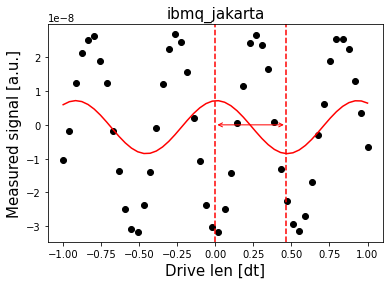

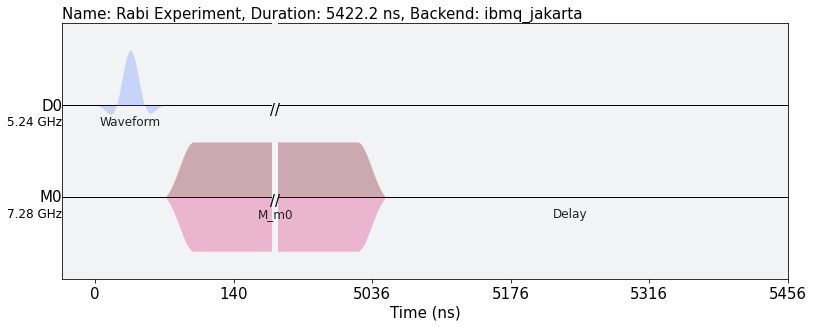

In [120]:
signal = Su22.Custom_Fgp('low_freq',test,backend)
#print(signal.input)
#print(signal.norm)
signal.draw()

In [121]:
print(signal.pi_p)

0.4632160130068034


In [129]:
test=np.array(data)
print(np.abs(test).max())
test= test/test.max()
t = time.time()
start=0.3
end=start+((0.98-0.02)/10)
all_probs, circ_batch= Spec(test*0.252,0.02,0.98,100,backend=backend)
circ_batch[0].draw()

17.108423954501


ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:25,124: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:28,171: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:31,182: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:34,194: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:37,244: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:40,260: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21:59:43,271: Maximum retries exceeded: Error checking job status due to a network error.
ibmqjob._wait_for_completion:ERROR:2022-07-15 21

IBMQManagedResultDataNotAvailable: 'Result data for experiment 600 is not available.'

Text(0.5, 0, 'Center Frequency')

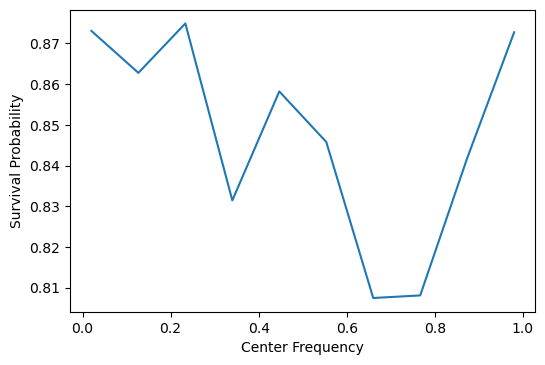

In [110]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_probs[:,0], all_probs[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [ ]:
print(len(circ_batch))
print(all_probs[0][0])

In [19]:
circ = QuantumCircuit(1)
signal.add_as_gate(circ,[0])
state = Full_tomography(circ, backend)
print(np.real(state))

NameError: name 'signal' is not defined

In [ ]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
plot_state_city(state)

In [ ]:
plot_bloch_multivector(state)

In [111]:
job= backend.retrieve_job('62d063a5efcea263995f4b59')
results = job.result()
prob = 0
counter = 0
num_center_freqs=10
center_idxs=[]
centers=[]
all_probs = np.zeros([num_center_freqs, 2])
num_noise_trajs= 30
circ_batch = np.zeros(300)
for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
cc=0
for i in range(int(len(circ_batch)/num_noise_trajs)):
    for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)]:
        zero_counts = results.get_counts(cc).get('1')
        prob += zero_counts/shots
        cc+=1
    prob = prob/num_noise_trajs
    all_probs[center_idxs[counter], :] = centers[counter], prob
    counter+=1
    prob=0

In [112]:
print(all_probs)

[[0.3        0.87306667]
 [0.40866667 0.86276667]
 [0.51733333 0.8749    ]
 [0.626      0.83143333]
 [0.73466667 0.8582    ]
 [0.84333333 0.8458    ]
 [0.952      0.80746667]
 [1.06066667 0.8081    ]
 [1.16933333 0.8418    ]
 [1.278      0.87273333]]


Text(0.5, 0, 'Center Frequency')

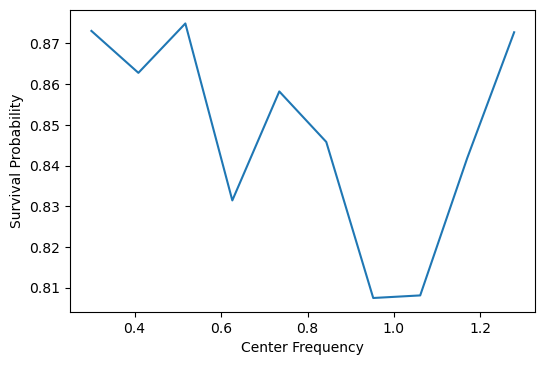

In [113]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_probs[:,0], all_probs[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [116]:
start+((0.98-0.02)/10)

0.396